<a href="https://colab.research.google.com/github/felixzhao/AIML425-ASSN-4/blob/main/notebooks/V6_VAE_SNR_Latent_Dist_AIML425_Assn_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install pot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 790.0/790.0 kB 16.0 MB/s eta 0:00:00


In [11]:
import numpy as np
import plotly.express as px

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import ot

import matplotlib.pyplot as plt
import plotly.express as px

# 1. Generate 3D data

In [3]:
def generate_points_on_cube_surface(n_points_per_face):
    """
    Generate points uniformly distributed over the surface of a cube.

    Parameters:
    - n_points_per_face: Number of points to generate on each face of the cube.

    Returns:
    - points: (3, 6*n_points_per_face) array of points on the cube surface.
    """
    faces = []
    for _ in range(6):
        face = np.random.rand(3, n_points_per_face)
        axis = _ // 2  # 0: x, 1: y, 2: z
        face[axis, :] = (_ % 2)  # 0 or 1, depending on the face
        faces.append(face)
    return np.hstack(faces)

# n_points_per_face = 1000
# points = generate_points_on_cube_surface(n_points_per_face)




# 2. Create a dataset and dataloaders

In [4]:
# points = points.T  # Transpose to have shape (n_samples, 3)

# # 2. Create a dataset and dataloaders
# dataset = TensorDataset(torch.tensor(points, dtype=torch.float32))
# dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

num_samples = 1200

points_raw = generate_points_on_cube_surface(num_samples // 6)
# points = generate_points_on_cube_surface(num_samples)
points = points_raw.T

dataset = TensorDataset(torch.tensor(points, dtype=torch.float32))
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


fig = px.scatter_3d(x=points_raw[0], y=points_raw[1], z=points_raw[2], opacity=0.5)
fig.show()

# 3. Define and train the autoencoder

## SNR

Adding i.i.d Gaussian noise to the latent (bottleneck) variable in a VAE is a form of regularization. Here's why it can be beneficial and how to think about tuning the Signal-to-Noise Ratio (SNR):

### Why Add Noise?

1. **Robustness**: Adding noise during training can make the model more robust. When the model is trained with noise, it learns to recover the underlying structure of the data despite the perturbations. This can help the model generalize better to unseen data.

2. **Prevent Overfitting**: Noise acts as a regularizer. By adding noise, you're effectively increasing the variability in the training data, which can prevent the model from fitting too closely to the training samples.

3. **Diverse Representations**: In the context of VAEs and generative models, adding noise can encourage the model to learn a more diverse range of latent representations. This can be especially useful if you want the model to capture a wide range of variations in the data.

4. **Smooth Latent Space**: Noise can help in smoothing the latent space. When noise is added, the model can't rely on very specific points in the latent space to reconstruct the data. This can lead to a more continuous and smooth latent space, which is desirable for many generative tasks.

### Tuning SNR:

1. **Start with Moderate SNR**: A moderate SNR means that the signal's strength is comparable to the noise level. This can be a good starting point. From there, you can experiment by increasing or decreasing the SNR.

2. **Validation Set**: Use a validation set to monitor the reconstruction error and, if applicable, other metrics relevant to your task. Adjust the SNR based on the performance on the validation set.

3. **Visual Inspection**: Especially for tasks like image generation, visual inspection can be a valuable tool. By looking at the reconstructed samples, you can get a sense of whether the noise level is too high (reconstructions are too noisy or distorted) or too low (reconstructions are too perfect and lack diversity).

4. **Trade-off**: There's a trade-off between noise level and reconstruction quality. Higher noise levels might lead to poorer reconstructions but might regularize the model better. It's essential to find a balance that suits your specific task and objectives.

5. **Task-specific Considerations**: Depending on your task, there might be other considerations. For instance, if you're using a VAE for anomaly detection, you might tune the SNR based on the anomaly detection performance on a validation set.

In summary, adding noise to the latent variable can be seen as a form of stochastic regularization. The optimal SNR will depend on the specific dataset, task, and objectives, and it's often found through experimentation and iterative refinement.

In [18]:
class VAEWithNoise(nn.Module):
    def __init__(self, input_dim, bottleneck_dim, snr):
        super(VAEWithNoise, self).__init__()

        self.snr = snr

        # Encoder
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc_mean = nn.Linear(128, bottleneck_dim)
        self.fc_logvar = nn.Linear(128, bottleneck_dim)

        # Decoder
        self.fc2 = nn.Linear(bottleneck_dim, 128)
        self.fc3 = nn.Linear(128, input_dim)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc_mean(h), self.fc_logvar(h)

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mean + eps * std

        # Add noise based on SNR
        signal_variance = z.var(dim=0, unbiased=False)
        noise_variance = signal_variance / self.snr
        noise = torch.randn_like(z) * torch.sqrt(noise_variance)

        z = z + noise
        return z

    def decode(self, z):
        h = F.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h))

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        return self.decode(z), mean, logvar


In [13]:
# Loss function
def vae_loss(reconstructed_x, x, mean, logvar):
    # Reconstruction loss
    BCE = F.binary_cross_entropy(reconstructed_x, x, reduction='sum')

    # KL divergence
    KLD = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())

    return BCE + KLD

# Eval Metric

## 1 Generative System:

In [14]:
def generate_samples(model, num_samples, latent_dim):
    model.eval()
    with torch.no_grad():
        # Sample from the prior distribution (standard Gaussian)
        z = torch.randn(num_samples, latent_dim)
        generated_samples = model.decode(z).cpu().numpy()
    return generated_samples

## 2. Quality Measure: Earth Mover's Distance (EMD):




2. Fréchet Inception Distance (FID):
For simplicity, let's assume you're working with images. If you're working with other types of data, the concept remains the same, but you'd need a different model than Inception v3 to compute features.

In [15]:
import ot

def compute_emd(samples1, samples2):
    # Compute pairwise distance matrix
    distance_matrix = ot.dist(samples1, samples2)

    # Compute EMD
    emd_value = ot.emd2([], [], distance_matrix)
    return emd_value

# train

In [ ]:
# Hyperparameters to tune
snr_values = [5, 10, 20, 50, 100]  # Example SNR values
latent_dims = [2, 3, 5, 7, 10]  # Example latent dimensionalities

best_emd = float('inf')
best_snr = None
best_latent_dim = None

for latent_dim in latent_dims:
    for snr in snr_values:
        # Initialize and train the VAE
        model = VAEWithNoise(3, latent_dim, snr)
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        num_epochs = 10
        for epoch in range(num_epochs):
            model.train()
            for batch, in dataloader:
                optimizer.zero_grad()
                reconstructed_batch, mean, logvar = model(batch)
                loss = vae_loss(reconstructed_batch, batch, mean, logvar)
                loss.backward()
                optimizer.step()

        # Generate samples and compute EMD
        generated_points = generate_samples(model, num_samples, latent_dim)
        emd_value = compute_emd(points, generated_points)

        print(f"Latent Dim: {latent_dim}, SNR: {snr}, EMD: {emd_value:.4f}")

        # Update best values
        if emd_value < best_emd:
            best_emd = emd_value
            best_snr = snr
            best_latent_dim = latent_dim

print(f"Best Latent Dim: {best_latent_dim}, Best SNR: {best_snr}, Best EMD: {best_emd:.4f}")

Latent Dim: 2, SNR: 5, EMD: 0.3837
Latent Dim: 2, SNR: 10, EMD: 0.3840
Latent Dim: 2, SNR: 20, EMD: 0.3754
Latent Dim: 2, SNR: 50, EMD: 0.3920
Latent Dim: 2, SNR: 100, EMD: 0.3605
Latent Dim: 3, SNR: 5, EMD: 0.3851
Latent Dim: 3, SNR: 10, EMD: 0.3751
Latent Dim: 3, SNR: 20, EMD: 0.3726
Latent Dim: 3, SNR: 50, EMD: 0.3728
Latent Dim: 3, SNR: 100, EMD: 0.3788
Latent Dim: 5, SNR: 5, EMD: 0.3662
Latent Dim: 5, SNR: 10, EMD: 0.3712
Latent Dim: 5, SNR: 20, EMD: 0.3689
Latent Dim: 5, SNR: 50, EMD: 0.3637
Latent Dim: 5, SNR: 100, EMD: 0.3634
Latent Dim: 7, SNR: 5, EMD: 0.3685
Latent Dim: 7, SNR: 10, EMD: 0.3696
Latent Dim: 7, SNR: 20, EMD: 0.3614
Latent Dim: 7, SNR: 50, EMD: 0.3629
Latent Dim: 7, SNR: 100, EMD: 0.3563
Latent Dim: 10, SNR: 5, EMD: 0.3652
Latent Dim: 10, SNR: 10, EMD: 0.3613
Latent Dim: 10, SNR: 20, EMD: 0.3510
Latent Dim: 10, SNR: 50, EMD: 0.3541
Latent Dim: 10, SNR: 100, EMD: 0.3606
Best Latent Dim: 10, Best SNR: 20, Best EMD: 0.3510


# 4. Evaluate the autoencoder

In [36]:
def plot_histograms(model, data_loader):
    """
    Plot histograms for each dimension of the bottleneck layer.

    Args:
    - model: The VAEWithNoise model.
    - data_loader: DataLoader containing the data to be passed through the model.
    """
    model.eval()  # Set the model to evaluation mode
    all_z = []

    with torch.no_grad():
        for batch_data, in data_loader:  # Note the comma to unpack the tuple
            mean, logvar = model.encode(batch_data)
            z = model.reparameterize(mean, logvar)
            all_z.append(z)

    all_z = torch.cat(all_z, dim=0)  # Concatenate all the bottleneck values
    num_dimensions = all_z.size(1)

    # Ensure you don't try to plot more subplots than dimensions
    num_rows, num_cols = 2, 5
    assert num_dimensions <= num_rows * num_cols, "Too many dimensions for the specified subplot grid."

    # Plot histograms
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 6))
    for i in range(num_dimensions):
        row = i // num_cols
        col = i % num_cols
        axes[row, col].hist(all_z[:, i].numpy(), bins=50, density=True)
        axes[row, col].set_title(f'Dimension {i + 1}')

    plt.tight_layout()
    plt.show()

In [38]:
def train_autoencoder():
    # Initialize the VAE model
    input_dim = 3  # For 3D data
    bottleneck_dim = 10
    snr = 10  # Adjust as needed
    model = VAEWithNoise(input_dim, bottleneck_dim, snr)

    # Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    # Training loop
    num_epochs = 10
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch, in dataloader:
            optimizer.zero_grad()
            reconstructed_batch, mean, logvar = model(batch)
            loss = vae_loss(reconstructed_batch, batch, mean, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss/len(dataset):.6f}")
    plot_histograms(model, dataloader)

Epoch 1/10, Loss: 2.175644
Epoch 2/10, Loss: 2.101669
Epoch 3/10, Loss: 2.094798
Epoch 4/10, Loss: 2.096318
Epoch 5/10, Loss: 2.097707
Epoch 6/10, Loss: 2.092114
Epoch 7/10, Loss: 2.088550
Epoch 8/10, Loss: 2.084350
Epoch 9/10, Loss: 2.085493
Epoch 10/10, Loss: 2.079922


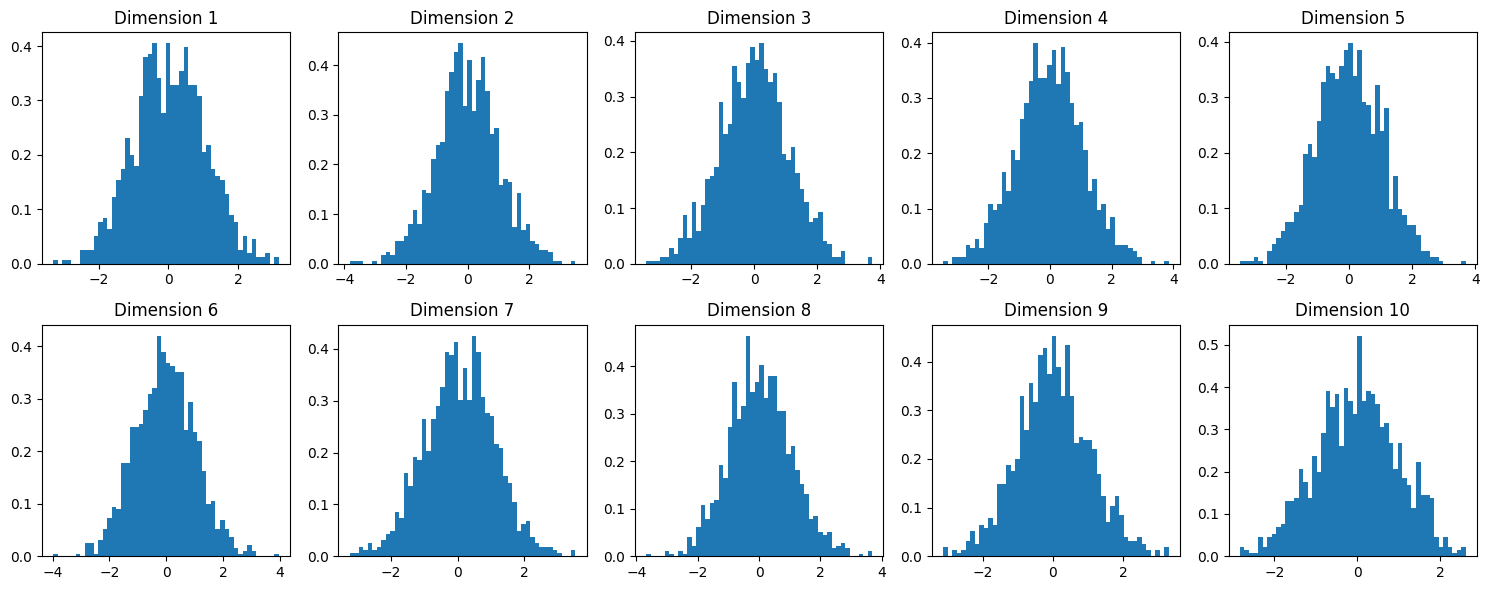

In [39]:
# round 1
train_autoencoder()

Epoch 1/10, Loss: 2.147585
Epoch 2/10, Loss: 2.099678
Epoch 3/10, Loss: 2.105928
Epoch 4/10, Loss: 2.099921
Epoch 5/10, Loss: 2.090213
Epoch 6/10, Loss: 2.088618
Epoch 7/10, Loss: 2.088551
Epoch 8/10, Loss: 2.084952
Epoch 9/10, Loss: 2.081632
Epoch 10/10, Loss: 2.088668


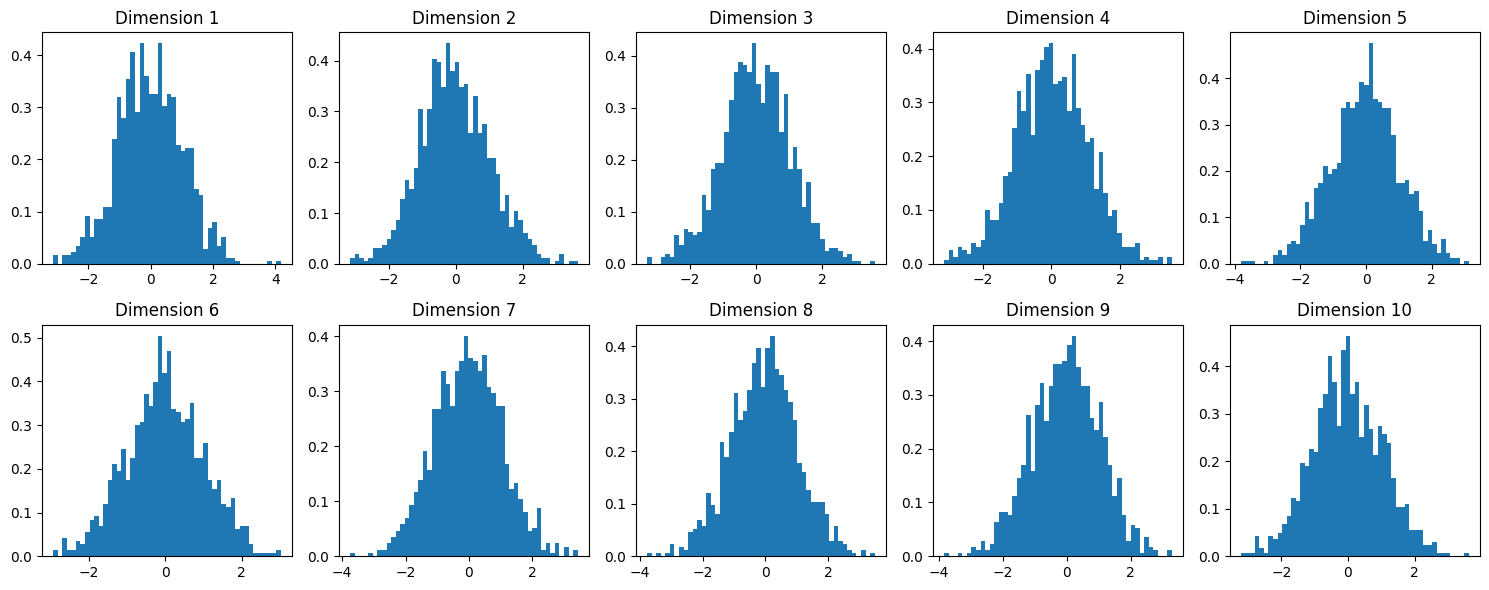

In [40]:
# round 2
train_autoencoder()

# Eval Model

In [10]:
# Evaluation
model.eval()
with torch.no_grad():
    # Reconstruction
    reconstructed = model(torch.tensor(points, dtype=torch.float32))[0].numpy()

    # Visualization (using plotly as before)
    fig = px.scatter_3d(x=points[:, 0], y=points[:, 1], z=points[:, 2], opacity=0.5, title="Original Points")
    fig.show()

    fig = px.scatter_3d(x=reconstructed[:, 0], y=reconstructed[:, 1], z=reconstructed[:, 2], opacity=0.5, title="Reconstructed Points")
    fig.show()

    # If bottleneck_dim is 2, you can also visualize the latent space
    mean, _ = model.encode(torch.tensor(points, dtype=torch.float32))
    mean = mean.numpy()
    fig = px.scatter(x=mean[:, 0], y=mean[:, 1], title="Latent Space")
    fig.show()
